27/10/2019 Developed by Xu Han (n10306986), Earl Chau (N10306986), Tzu-Wen Chen (N7588844)

**Synopsis** <br>
Siamese neural network is an Artificial Neural Network (ANN) 
 that uses the same weights and structure while working 
 in tandem on 2 dissimilar input vectors to compute comparable output vectors.
 
 In this experiment, three Siamese Neural Networks were implemented to learn the correspondence classes 
 from the image pairs prepared. Furthermore, the model was first trained to ensure the pairs of images 
 with the same clothing type to yield a closer output vectors 
 than that of the pair of images from the different clothing types.
 
 The models were then was used to differentiate the similarity metric 
 between the trained input clothing 
 with that of the new samples from unseen categories.
 
 Fashion-MNIST dataset contains 70,000 28x 28 grayscale unique fashion clothing images in 10 different classifications. 
 In which these classes comprised: top, trouser, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot. 

**Update Ver 1.1** <br/>
19/04/2022 Edited by Xu Han 
 Optimise the code of Margin Values testing

In [2]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.utils import to_categorical

from keras import regularizers
from keras import backend as K
from keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten, Lambda, Input, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.utils import shuffle

In [4]:
def euclidean_distance(vects):
    '''
    The function will compute the distance between two vectors in a Keras layer
    by using Euclidian Distance Formula.
    @param:  vects (two input images)
    @return: the value of distance
    '''
    x1, x2 = vects
    return K.sqrt(K.maximum(K.sum(K.square(x1 - x2), axis=1, keepdims=True), K.epsilon()))

In [63]:
# The global value is for testing the contrastive loss function by changing the margin value
# The default value is set to 1 during conducting experiment
# The value will be changed during the testing process
margin = 1

In [64]:
def contrastive_loss(y_true, y_pred):
    '''
    @param
      y_true : 0 = same equivalence class, 1 = different equivalence class
      y_pred : the distance calculated by the function 'euclidean_distance'
    @return
      the value of contrastive loss value
    '''

    # if the pair of impages are not in the same classes (y_true = 1),
    #    the penalty will calculate the formula 'K.mean(K.square(K.maximum(margin - y_pred, 0)))',
    #    which is given for the distance that is smaller than the margin

    # if the pair of impages are in the same classes (y_true = 0),
    #    the penalty will calculate the formula 'K.mean(K.square(y_pred))',
    #    which is given for the distance returned by Siamese network
    
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [6]:
def accuracy(y_true, y_pred):
    '''
    The function will compute classification accuracy with a fixed threshold on distances, in the tensor layer.
    @param 
      y_true : 0 = positive pair, 1 = negative pair
      y_pred : the distance calculated by the function 'euclidean_distance'
    @return the value for training accuracy
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [7]:
def create_pairs(images, digit_indices, num_classes):
    '''
    Create positive and negative pair. 
    Alternates between positive and negative pairs.
    @param:  images, digit_indices, num_classes      
    @return: the pairs of positive and negative, with labels [1,0]
    '''  
    pairs = []
    labels = []
    lengh = len(num_classes)
    # digit indices contains images classified
      # e.g. class 1 -> [[Image1],[Image2] ... [ImageN]]
      # e.g. class 2 -> [[Image1],[Image2] ... [ImageN]]
      # ...
      # e.g. class 9 -> [[Image1],[Image2] ... [ImageN]]
    # Get the minimum number of images 'n' from digit_indices
    # The number 'n' is to ensure all created pairs having the same quantity 
    # n - 1 is for the loop reason as we will have adjecent pairs [i] & [i+1] 
    n = min([len(digit_indices[i]) for i in range(lengh)]) - 1
    for d in range(lengh):
        # Each loop creates a postive pair and a negative pair, with same equivalence label [1,0]
        for i in range(n):
            # Create a positive pair
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[images[z1], images[z2]]]
            
            # Pick a random image from other classes
            # Ensure the collected images absolute in different classes
            inc = random.randrange(1, lengh)
            dn = (d + inc) % lengh
         
            # Create a negative pair
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[images[z1], images[z2]]]
            
            # Create label pairs
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [18]:
def define_CNNlayer_parameters():
    '''
    The function is cited from Tutorial 10 for exploring suitable parameters for CNN network 1, with small size of samples. 
    Finding the best network parmeter in candidate parmeter by Gridsearch method. 
    @param: train_images, train_labels, test_images, test_labels
    @return: the suggested candidate parmter for current model
    '''
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    
    #For faster training during the practival, reduce the number of examples
    x_train, y_train = shuffle(x_train, y_train, random_state=0)
    x_test, y_test = shuffle(x_test, y_test, random_state=0)
    x_train = x_train[:2000]
    y_train = y_train[:2000]
    x_test = x_test[:100]
    y_test = y_test[:100]
    
    img_rows, img_cols = x_train.shape[1:3]
    num_classes = len(np.unique(y_train))
    # reshape the input arrays to 4D (batch_size, rows, columns, channels)
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)    
    
    # convert to float32 and rescale between 0 and 1
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    epochs = 3
    batch_size = 128
     # Define CNN Network 1
    def make_model(filters, kernel_size, pool_size, dense_layer_size):
        '''
        Building the architecture of the model based on LeNet-5.  
        @param: 
        dense_layer_sizes: List of layer sizes to be chosen
        filters: Number of convolutional filters in each convolutional layer
        kernel_size: Convolutional kernel size
        pool_size: Size of pooling area for max pooling
        @reutrn: CNN model
        '''
        seq = Sequential()
        # Fully connected layer
        seq.add(Convolution2D(filters, kernel_size = kernel_size,
        activation = 'relu',
        input_shape = input_shape))
        seq.add(MaxPooling2D(pool_size = pool_size,
                strides = (2, 2),    
                padding = 'same'))
        seq.add(Convolution2D(filters, kernel_size = kernel_size, activation = 'relu')) 
        seq.add(MaxPooling2D(pool_size = pool_size,
                strides = (2, 2),    
                padding = 'same'))    
        # Fully connected layer
        seq.add(Flatten())
        seq.add(Dense(dense_layer_size, activation='relu')) 
        seq.add(Dense(dense_layer_size, activation='relu'))    
        seq.add(Dense(num_classes, activation='softmax'))
        
        seq.compile(loss='categorical_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])
        return seq
    
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    
    # Create a classifier using the defined CNN model
    my_classifier = KerasClassifier(make_model, verbose=1) 
    
    # Define candidate parameter values for the following parameters
    param_grid = {'dense_layer_size': [64, 84, 120], 'filters': [32, 64], 'kernel_size': [2, 3], 'pool_size': [2]}
    
    # Create an object of GridSearchCV for finding the best parameters 
    validator = model_selection.GridSearchCV(my_classifier, param_grid = param_grid, cv = 10,  verbose=0)   
    
    # Training the model to fit the train dataset
    validator.fit(x_train, y_train,  
                      batch_size = batch_size,
                      epochs=epochs,
                      verbose=1) 
    
    # Return and print the best parameters
    print('\nThe parameters of the best model are: ')
    print(validator.best_params_)

    # validator.best_estimator_.model returns the (unwrapped) keras model
    best_model = validator.best_estimator_.model
    metric_names = best_model.metrics_names
    metric_values = best_model.evaluate(x_test, y_test)
    for metric, value in zip(metric_names, metric_values):
        print(metric, ': ', value)
        
    means = validator.cv_results_['mean_test_score']
    for mean, params in zip(means, validator.cv_results_['params']):
        print("%0.3f for %r"
              % (mean, params))
        print()
    pass

In [9]:
def show_images(images, name):
    '''
    The function shows pairs of images for verifying that the dateset is seperated properly.  
    @param: images, name    
    '''
    print(name + " : " + "Positive Images")
    plt.figure(figsize=(10,10))
    for i in range(2):
        plt.subplot(1,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i][0].reshape(28, 28), cmap=plt.cm.binary)
    plt.show()
    
    print(name + " : " + "Negative Images")
    plt.figure(figsize=(10,10))
    for i in range(2):
        plt.subplot(1,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i][1].reshape(28, 28), cmap=plt.cm.binary)
    plt.show()
    pass

In [10]:
def create_base_network_1(input_shape):
    '''
    Create CNN Nerual Network with 7 layers for the experiment 1
    Conv(32) -> MaxPooling() -> Conv(64) -> Flatten -> Dense(120) -> Dense(84) -> Dense(10)
    @param:  input_shape with 3-dimentions | (28, 28, 1)
    @return: CNN Nerual Network (Sequential)
    '''
    seq = Sequential()
    # Partially connected layer
    seq.add(Convolution2D(32, kernel_size = (3, 3),
        activation = 'relu',
        input_shape = input_shape))
    seq.add(MaxPooling2D(pool_size = (2, 2),
            strides = (2, 2),    
            padding = 'same'))
    seq.add(Convolution2D(64, (3, 3), activation = 'relu')) 
    seq.add(MaxPooling2D(pool_size = (2, 2),
            strides = (2, 2),    
            padding = 'same'))    
    # Fully connected layer
    seq.add(Flatten())
    seq.add(Dense(120, activation='relu')) 
    seq.add(Dense(84, activation='relu'))    
    seq.add(Dense(10, activation='softmax'))
    seq.summary()
    return seq

In [11]:
def create_base_network_2(input_shape):
    '''
    Create CNN Nerual Network with 8 layers for the experiment 2
    Conv(32) -> MaxPooling -> Conv(64) -> MaxPooling() -> Flatten() -> Dense(120) -> Dense(84) -> Dense(10)
    @param:  input_shape with 3-dimentions | (28, 28, 1)
    @return: CNN Nerual Network (Sequential)
    '''
    seq = Sequential()
    # Partially connected layer
    seq.add(Convolution2D(32, kernel_size = (3, 3),
        activation = 'relu',
        input_shape = input_shape))
    seq.add(MaxPooling2D(pool_size = (2, 2),
            strides = (2, 2),    
            padding = 'same'))
    seq.add(Convolution2D(64, (3, 3), activation = 'relu')) 
    seq.add(MaxPooling2D(pool_size = (2, 2),
            strides = (2, 2),    
            padding = 'same'))    
    # Fully connected layer
    seq.add(Flatten())
    seq.add(Dense(120, activation='relu', 
              kernel_regularizer=regularizers.l2(0.01),
              bias_regularizer=regularizers.l1(0.01)))
    seq.add(Dense(84, activation='relu'))
    seq.add(Dense(10, activation='softmax'))
    seq.summary()
    return seq

In [12]:
def create_base_network_3(input_shape):
    '''
    Create CNN Nerual Network with 9 layers for the experiment 3
    Conv(32) -> MaxPooling -> Conv(64) ->  MaxPooling() -> Flatten() -> Dense(120) ->  Dropout() -> Dense(84) -> Dense(10)
    @param:  input_shape with 3-dimentions | (28, 28, 1)
    @return: CNN Nerual Network (Sequential)
    '''
    seq = Sequential()
    # Partially connected layer
    seq.add(Convolution2D(32, kernel_size = (3, 3),
        activation = 'relu',
        input_shape = input_shape))
    seq.add(MaxPooling2D(pool_size = (2, 2),
            strides = (2, 2),    
            padding = 'same'))
    seq.add(Convolution2D(64, (3, 3), activation = 'relu')) 
    seq.add(MaxPooling2D(pool_size = (2, 2),
            strides = (2, 2),    
            padding = 'same'))    
    # Fully connected layer
    seq.add(Flatten())
    seq.add(Dense(120, activation='relu', 
                  kernel_regularizer=regularizers.l2(0.01),
                  bias_regularizer=regularizers.l1(0.01)))
    seq.add(Dropout(0.25))
    seq.add(Dense(84, activation='relu'))
    seq.add(Dense(10, activation='softmax'))
    seq.summary()
    return seq

In [13]:
def show_plot(history):
    '''
    Plot the accurary & loss line for the comparison.
    Plot 5 lines within one graph, with 1 trainning line and 4 testing lines
    @param:  histories(containing the training info), legends
    '''
    plt.plot(history.history['accuracy'], color = "Black")
    plt.plot(history.history['val_accuracy'], color = "Red")
    plt.title('Siamese Network - Accuracy')
    plt.ylabel('Percent')
    plt.xlabel('Epoch')
    plt.legend(['train_acc','val_acc'],loc='lower right')
    plt.show()
    
    plt.plot(history.history['loss'], color = "Black")
    plt.plot(history. history['val_loss'], color = "Red")
    plt.title('Siamese Network - Loss')
    plt.ylabel('Percent')
    plt.xlabel('Epoch')
    plt.legend(['train_loss','val_loss'],loc='upper right')
    plt.show()
    pass

In [55]:
def get_data():
    '''
    Obtain data online and do following processes: 
        1. Data Combination
        2. Data Classification
        3. Data Optimisation
        4. Data Normalisation
        5. Create Postive & Negative Pairs
        6. Data Verification
    @return: three sets of pairs for training and testing & input_shape
    '''
    # Load data online
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
        
    # Data combinatian (images + labels) 60,000 + 10,000
    full_images = np.concatenate((train_images,test_images))
    full_labels = np.concatenate((train_labels,test_labels))
        
    img_rows, img_cols = full_images.shape[1:3]
    input_shape = (img_rows, img_cols, 1)
        
    # Data Classification such that:
    #    * keep 80% of images with labels in ["top", "trouser", "pullover", "coat", "sandal", "ankle boot"] are
    #      used for training, while 20% of which is used for testing
    #    * the images with labels in ["dress", "sneaker", "bag", "shirt"] are only used for testing.
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    num_classes_1, num_classes_2 = [0,1,2,4,5,9], [3,6,7,8]
    images_set_1, labels_set_1 = [], []
    test_images_1, test_labels_1 = [], []
    
    for i in range(len(full_images)):
      if full_labels[i] in num_classes_1:
        images_set_1.append(full_images[i])
        labels_set_1.append(full_labels[i])
      elif full_labels[i] in num_classes_2:
        test_images_1.append(full_images[i])
        test_labels_1.append(full_labels[i])
        
    # Convert the data type to nparray
    images_set_1 = np.array(images_set_1)
    labels_set_1 = np.array(labels_set_1)
    test_images_1 = np.array(test_images_1)
    test_labels_1 = np.array(test_labels_1)
    
    # Split the data into 8:2 for training & testing    
    train_images_1, test_images_2, train_labels_1, test_labels_2 = model_selection.train_test_split(images_set_1, labels_set_1, test_size = 0.2)
    
    # Combine the 100% of images with labels in ["dress", "sneaker", "bag", "shirt"]
    # and the 20% of images with labels in ["top", "trouser", "pullover", "coat", "sandal", "ankle boot"
    test_images_3 = np.concatenate((test_images_1, test_images_2))
    test_labels_3 = np.concatenate((test_labels_1, test_labels_2))
        
    # Data Optimisation
    #  - Reshape image arrays to 4D (batch_size, rows, columns, channels)
    train_images_1 = train_images_1.reshape(train_images_1.shape[0], img_rows, img_cols, 1) # 80%
    test_images_1 = test_images_1.reshape(test_images_1.shape[0], img_rows, img_cols, 1) # 100%
    test_images_2 = test_images_2.reshape(test_images_2.shape[0], img_rows, img_cols, 1) # 20%
    test_images_3 = test_images_3.reshape(test_images_3.shape[0], img_rows, img_cols, 1) # 100% + 20%
    
    # Data Nomorlisationa
    # 1. alter data type to float32
    # 2. convert to float32 and rescale between 0 and 1
    train_images_1 = train_images_1.astype("float32")
    test_images_1 = test_images_1.astype("float32")
    test_images_2 = test_images_2.astype("float32")
    test_images_3 = test_images_3.astype("float32")

    train_images_1 /= 255
    test_images_1 /= 255
    test_images_2 /= 255
    test_images_3 /= 255
    
    # Create training & testing positive and negative pairs for 4 sets of data
    # num_classes_1, num_classes_2 = [0,1,2,4,5,9], [3,6,7,8]
    # class_names = [0,1,2,3,4,5,6,7,8,9]
    digit_indices = [np.where(train_labels_1 == num_classes_1[i])[0] for i in range(len(num_classes_1))]
    train_pairs_1, train_pairs_labels_1 = create_pairs(train_images_1, digit_indices, num_classes_1)
    
    digit_indices = [np.where(test_labels_1 == num_classes_2[i])[0] for i in range(len(num_classes_2))]
    test_pairs_1, test_pairs_labels_1 = create_pairs(test_images_1, digit_indices, num_classes_2)
    
    digit_indices = [np.where(test_labels_2 == num_classes_1[i])[0] for i in range(len(num_classes_1))]
    test_pairs_2, test_pairs_labels_2 = create_pairs(test_images_2, digit_indices, num_classes_1)
    
    # The data contains all classes
    digit_indices = [np.where(test_labels_3 == i)[0] for i in range(len(class_names))]
    test_pairs_3, test_pairs_labels_3 = create_pairs(test_images_3, digit_indices, class_names)

    global initiated
    # Following codes will be skipped after the first execution.
    if (initiated == False):
        # Data Verification
        # Image with labels [0,1,2,4,5,9] = 42000
        # 80% of image with labels [0,1,2,4,5,9] = 33600
        # 20% of image with labels [0,1,2,4,5,9] =  8400
        # Image with labels [3,6,7,8] =  28000
        # 20% of image with labels [0,1,2,4,5,9] + 100% of image with labels [3,6,7,8] =  36400
        print("*** Total images === ", full_images.shape[0])
        print("*** Total image labels === ", np.unique(full_labels))
        print("*** Image with labels [0,1,2,4,5,9] === ", images_set_1.shape[0])
        print("*** Image labels [0,1,2,4,5,9] === ", np.unique(labels_set_1))
        print("*** Image with labels [3,6,7,8] === ", test_images_1.shape[0])
        print("*** Image labels [3,6,7,8] === ", np.unique(test_labels_1))
        print("*** 80% of image with labels [0,1,2,4,5,9] === ", train_images_1.shape[0])
        print("*** 80% of image labels [0,1,2,4,5,9] === ", np.unique(train_labels_1))
        print("*** 20% of image with labels [0,1,2,4,5,9] === ", test_images_2.shape[0])
        print("*** 20% of image labels [0,1,2,4,5,9] === ", np.unique(test_labels_2))
        print("*** 20% of image with labels [0,1,2,4,5,9] + 100% of image with labels [3,6,7,8] === ", test_images_3.shape[0])
        print("*** 20% of image labels [0,1,2,4,5,9] + 100% of image labels [3,6,7,8] === ", np.unique(test_labels_3))
    
        show_images(train_pairs_1, "SET_1")
        show_images(test_pairs_1,  "SET_2")
        show_images(test_pairs_2,  "SET_3")
        show_images(test_pairs_3,  "SET_4")
        
        initiated = True
    
    return (train_pairs_1, train_pairs_labels_1), (test_pairs_1, test_pairs_labels_1), (test_pairs_2, test_pairs_labels_2), (test_pairs_3, test_pairs_labels_3), input_shape


In [23]:
def create_siamese_network(network_mode, input_shape):
    '''
    initiate Siamese network with different network_mode.
    @params: network_mode, input_shape
    @return: model (Siamese Network)
    '''
    
    # Network initialisation 
    base_network = Sequential()
    if network_mode == 1:
        base_network = create_base_network_1(input_shape)
    elif network_mode == 2:
        base_network = create_base_network_2(input_shape)
    else:
        base_network = create_base_network_3(input_shape)
        
    # Initiate the shape for two tensors
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
   
    # Use the same base_network to input two tensors with sharing weights of the network
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    
    # Lambda Layer for calculating two tensors by using Euclidian Distance
    distance = Lambda(euclidean_distance)([processed_a, processed_b])
    
    # Model Initialisation
    model = Model([input_a, input_b], distance)
    model.compile(loss=contrastive_loss, optimizer=Adadelta(), metrics=[accuracy])
    return model

In [34]:
def create_base_network_1(input_shape):
    '''
    Create CNN Nerual Network with 7 layers for the experiment 1
    Conv(32) -> MaxPooling() -> Conv(64) -> Flatten -> Dense(120) -> Dense(84) -> Dense(10)
    @param:  input_shape with 3-dimentions | (28, 28, 1)
    @return: CNN Nerual Network (Sequential)
    '''
    seq = Sequential()
    # Partially connected layer
    seq.add(Convolution2D(32, kernel_size = (3, 3),
        activation = 'relu',
        input_shape = input_shape))
    seq.add(MaxPooling2D(pool_size = (2, 2),
            strides = (2, 2),    
            padding = 'same'))
    seq.add(Convolution2D(64, (3, 3), activation = 'relu')) 
    seq.add(MaxPooling2D(pool_size = (2, 2),
            strides = (2, 2),    
            padding = 'same'))    
    # Fully connected layer
    seq.add(Flatten())
    seq.add(Dense(120, activation='relu')) 
    seq.add(Dense(84, activation='relu'))    
    seq.add(Dense(10, activation='softmax'))
    seq.summary()
    return seq

In [35]:
def create_base_network_2(input_shape):
    '''
    Create CNN Nerual Network with 8 layers for the experiment 2
    Conv(32) -> MaxPooling -> Conv(64) -> MaxPooling() -> Flatten() -> Dense(120) -> Dense(84) -> Dense(10)
    @param:  input_shape with 3-dimentions | (28, 28, 1)
    @return: CNN Nerual Network (Sequential)
    '''
    seq = Sequential()
    # Partially connected layer
    seq.add(Convolution2D(32, kernel_size = (3, 3),
        activation = 'relu',
        input_shape = input_shape))
    seq.add(MaxPooling2D(pool_size = (2, 2),
            strides = (2, 2),    
            padding = 'same'))
    seq.add(Convolution2D(64, (3, 3), activation = 'relu')) 
    seq.add(MaxPooling2D(pool_size = (2, 2),
            strides = (2, 2),    
            padding = 'same'))    
    # Fully connected layer
    seq.add(Flatten())
    seq.add(Dense(120, activation='relu', 
              kernel_regularizer=regularizers.l2(0.01),
              bias_regularizer=regularizers.l1(0.01)))
    seq.add(Dense(84, activation='relu'))
    seq.add(Dense(10, activation='softmax'))
    seq.summary()
    return seq

In [36]:
def create_base_network_3(input_shape):
    '''
    Create CNN Nerual Network with 9 layers for the experiment 3
    Conv(32) -> MaxPooling -> Conv(64) ->  MaxPooling() -> Flatten() -> Dense(120) ->  Dropout() -> Dense(84) -> Dense(10)
    @param:  input_shape with 3-dimentions | (28, 28, 1)
    @return: CNN Nerual Network (Sequential)
    '''
    seq = Sequential()
    # Partially connected layer
    seq.add(Convolution2D(32, kernel_size = (3, 3),
        activation = 'relu',
        input_shape = input_shape))
    seq.add(MaxPooling2D(pool_size = (2, 2),
            strides = (2, 2),    
            padding = 'same'))
    seq.add(Convolution2D(64, (3, 3), activation = 'relu')) 
    seq.add(MaxPooling2D(pool_size = (2, 2),
            strides = (2, 2),    
            padding = 'same'))    
    # Fully connected layer
    seq.add(Flatten())
    seq.add(Dense(120, activation='relu', 
                  kernel_regularizer=regularizers.l2(0.01),
                  bias_regularizer=regularizers.l1(0.01)))
    seq.add(Dropout(0.25))
    seq.add(Dense(84, activation='relu'))
    seq.add(Dense(10, activation='softmax'))
    seq.summary()
    return seq

In [57]:
def train_network(network_mode, epochs, test_mode):
    '''
    train Siamese network based on network_mode.
    @params: 
        network_mode:
            # 1 = Siamese Network Ex1 
            # 2 = Siamese Network EX2
            # 3 = Siamese Network Ex3
        epochs: it refers training times.
        test_mode: 0 = conduct experiments / 1 = testing loss function
    @return: model (Siamese Network)
    '''
    
    # Trainning Data : 80% of image pairs in labels with ["top", "trouser", "pullover", "coat", "sandal", "ankle boot"]
    # SET1 : train_pairs_1 & train_pairs_labels_1: 
    #  - 80% of image pairs in labels with ["top", "trouser", "pullover", "coat", "sandal", "ankle boot"] 
    # SET2 : test_pairs_1 & test_pairs_labels_1: 
    #  - 100% of image pairs with labels in ["dress", "sneaker", "bag", "shirt"] are only used for testing
    # SET3 : test_pairs_2, test_pairs_labels_2: 
    #  - 20% of image pairs in labels with ["top", "trouser", "pullover", "coat", "sandal", "ankle boot"] 
    # SET4 : test_pairs_3, test_pairs_labels_3: 
    #  - image pairs with all labels are only used for testing
    # input_shape: (28, 28, 1)   
    
    (train_pairs_1, train_pairs_labels_1), (test_pairs_1, test_pairs_labels_1), (test_pairs_2, test_pairs_labels_2), (test_pairs_3, test_pairs_labels_3), input_shape = get_data()

    #! The code is updated to suit Tensorflow 2 by 20/04/2022
    train_pairs_1 = train_pairs_1.astype("float32")
    train_pairs_labels_1 = train_pairs_labels_1.astype("float32")

    test_pairs_1 = test_pairs_1.astype("float32")
    test_pairs_labels_1 = test_pairs_labels_1.astype("float32")

    test_pairs_2 = test_pairs_2.astype("float32")
    test_pairs_labels_2 = test_pairs_labels_2.astype("float32")

    test_pairs_3 = test_pairs_3.astype("float32")
    test_pairs_labels_3 = test_pairs_labels_3.astype("float32")
    # End

    batch_size = 128
    global margin
    # Training Siamese Network
    if(test_mode == 0):
        margin = 1
        # SET1: Training & Testing 
        model = create_siamese_network(network_mode, input_shape)
        history = model.fit([train_pairs_1[:, 0], train_pairs_1[:, 1]], train_pairs_labels_1,
                  batch_size=batch_size,
                  epochs=epochs, 
                  verbose=1,
                  validation_data=([test_pairs_2[:, 0], test_pairs_2[:, 1]], test_pairs_labels_2))
        # Plot the training result (contains Acc + Loss)
        show_plot(history)
        
        # SET2: Evaluation 
        score = model.evaluate([test_pairs_1[:, 0], test_pairs_1[:, 1]], test_pairs_labels_1, verbose = 0)
        print('SET_2 -> Test Loss = %0.2f%%' % (100 * score[0]))
        print('SET_2 -> Test Accuracy = %0.2f%%' % (100 * score[1]))
        
        # SET3: Evaluation 
        score = model.evaluate([test_pairs_2[:, 0], test_pairs_2[:, 1]], test_pairs_labels_2, verbose = 0)
        print('SET_3 -> Test Loss = %0.2f%%' % (100 * score[0]))
        print('SET_3 -> Test Accuracy = %0.2f%%' % (100 * score[1]))
        
        # SET4: Evaluation 
        score = model.evaluate([test_pairs_3[:, 0], test_pairs_3[:, 1]], test_pairs_labels_3, verbose = 0)
        print('SET_4 -> Test Loss = %0.2f%%' % (100 * score[0]))
        print('SET_4 -> Test Accuracy = %0.2f%%' % (100 * score[1]))    
    else:
        # Testing the margin value m in contrasrtive loss function
        # We choose SET2 and Network 3 to conduct the margin value experment
        # We will compare and record the result by changing the margin value in the contrastive loss function
        # [The reason why we choose the dataset and network will specify in report]         
        for val in [0.55, 0.75, 1, 1.25, 1.5]:
          margin = val
          model = create_siamese_network(network_mode, input_shape)
          model.fit([train_pairs_1[:, 0], train_pairs_1[:, 1]], train_pairs_labels_1,
                    batch_size=batch_size,
                    epochs=epochs, 
                    verbose=1,
                    validation_data=([test_pairs_2[:, 0], test_pairs_2[:, 1]], test_pairs_labels_2))
          score = model.evaluate([test_pairs_2[:, 0], test_pairs_2[:, 1]], test_pairs_labels_2, verbose = 0)
          print('SET_2 (Margin = %0.2f) -> Test Loss = %0.2f%%' % (margin, 100 * score[0]))
          print('SET_2 (Margin = %0.2f) -> Test Accuracy = %0.2f%%' % (margin, 100 * score[1]))

In [19]:
# Explore the best parameters for CNN network 1 
define_CNNlayer_parameters()

x_train shape: (2000, 28, 28, 1)
2000 train samples
100 test samples
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


15/15 [==============================] - 1s 10ms/step - loss: 2.2961 - accuracy: 0.1806
Epoch 2/3
15/15 [==============================] - 0s 10ms/step - loss: 2.2957 - accuracy: 0.1822
Epoch 3/3
7/7 [==============================] - 0s 5ms/step - loss: 2.2993 - accuracy: 0.1750
Epoch 1/3
15/15 [==============================] - 1s 9ms/step - loss: 2.3156 - accuracy: 0.0600
Epoch 2/3
15/15 [==============================] - 0s 10ms/step - loss: 2.3151 - accuracy: 0.0633
Epoch 3/3
7/7 [==============================] - 0s 4ms/step - loss: 2.3059 - accuracy: 0.0850
Epoch 1/3
15/15 [==============================] - 1s 9ms/step - loss: 2.2985 - accuracy: 0.1439
Epoch 2/3
15/15 [==============================] - 0s 9ms/step - loss: 2.2982 - accuracy: 0.1461
Epoch 3/3
7/7 [==============================] - 0s 4ms/step - loss: 2.2885 - accuracy: 0.1650
Epoch 1/3
15/15 [==============================] - 1s 10ms/step - loss: 2.3029 - accuracy: 0.0906
Epoch 2/3
15/15 [=========================

# Training Siamese Network


In [20]:
# 1st Param: 
        # 1 = Open Siamese Network Ex1 
        # 2 = Open Siamese Network EX2
        # 3 = Open Siamese Network Ex3 (Best)
# 2nd Param: Epochs
# 3rd Param: 0 = conduct experiments / 1 = testing loss function (margin change)

In [59]:
# Stamp for opening Data Verification at the first execution
initiated = False

*** Total images ===  70000
*** Total image labels ===  [0 1 2 3 4 5 6 7 8 9]
*** Image with labels [0,1,2,4,5,9] ===  42000
*** Image labels [0,1,2,4,5,9] ===  [0 1 2 4 5 9]
*** Image with labels [3,6,7,8] ===  28000
*** Image labels [3,6,7,8] ===  [3 6 7 8]
*** 80% of image with labels [0,1,2,4,5,9] ===  33600
*** 80% of image labels [0,1,2,4,5,9] ===  [0 1 2 4 5 9]
*** 20% of image with labels [0,1,2,4,5,9] ===  8400
*** 20% of image labels [0,1,2,4,5,9] ===  [0 1 2 4 5 9]
*** 20% of image with labels [0,1,2,4,5,9] + 100% of image with labels [3,6,7,8] ===  36400
*** 20% of image labels [0,1,2,4,5,9] + 100% of image labels [3,6,7,8] ===  [0 1 2 3 4 5 6 7 8 9]
SET_1 : Positive Images


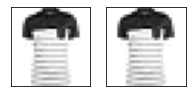

SET_1 : Negative Images


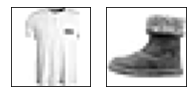

SET_2 : Positive Images


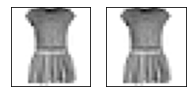

SET_2 : Negative Images


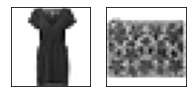

SET_3 : Positive Images


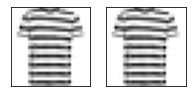

SET_3 : Negative Images


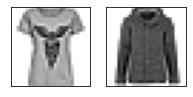

SET_4 : Positive Images


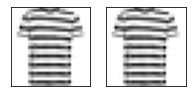

SET_4 : Negative Images


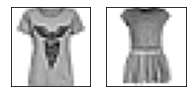

Model: "sequential_267"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_508 (Conv2D)         (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_508 (MaxPooli  (None, 13, 13, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_509 (Conv2D)         (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_509 (MaxPooli  (None, 6, 6, 64)         0         
 ng2D)                                                           
                                                                 
 flatten_254 (Flatten)       (None, 2304)              0         
                                                                 
 dense_762 (Dense)           (None, 120)            

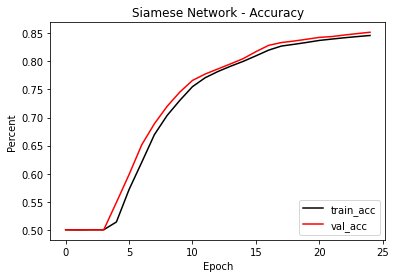

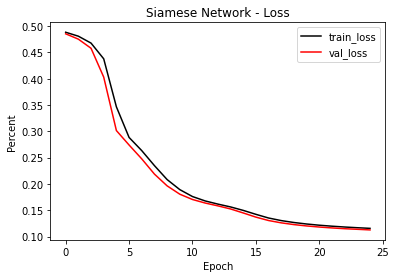

SET_2 -> Test Loss = 13.28%
SET_2 -> Test Accuracy = 80.95%
SET_3 -> Test Loss = 11.25%
SET_3 -> Test Accuracy = 85.20%
SET_4 -> Test Loss = 14.22%
SET_4 -> Test Accuracy = 80.22%


In [60]:
train_network(1, 25, 0)

In [ ]:
train_network(2, 25, 0)

In [ ]:
train_network(3, 25, 0)

In [ ]:
# Margin Sets [0.55, 0.75, 1.00, 1.25, 1.5] will be put onto the training process respectively
# We had found Margin = 1 that is expected to produce the highest accuracy compared with other margin values.
train_network(3, 25, 1)